# **量子コンピュータを用いたプログラミング方法を学ぼう（量子アニーリング）**

## **初期設定**

このページを開いたらまず始めに "Copy to Drive" をクリックしてください。\
自分の Google Drive にこのファイルがコピーされます。

コピーができたらそのファイルを開いてください。\
以降はこのコピーしたファイル上で実行を行います。

**実行方法**

プログラムにカーソルをかざすと再生ボタンが出るのでそれをクリックしたら実行されます。\
また `Shift + Enter` でも実行できます。

## **Step0 量子フレームワークのダウンロード**

今回は量子アニーリング方式である D-Wave Systems 社の量子コンピュータを使ってみます。 \
この量子コンピュータを使用するためには `dwave-ocean-sdk` という量子フレームワークを用いてプログラミングを行います。

dwave-ocean-sdk: https://docs.ocean.dwavesys.com/en/stable/index.html

In [1]:
!pip install dwave-ocean-sdk==8.0.1
!pip install pyqubo==1.5.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.9/158.9 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.3/102.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.6/257.6 kB 6.

In [2]:
# データのインポート
import matplotlib.pyplot as plt
from IPython.display import IFrame

%matplotlib inline

## **Step1 古典：問題をQUBOに変換する**
量子アニーリング方式の量子計算を実行するためには以下の流れで行います。

1.   問題をQUBOに変換する。
2.   1で作成したQUBOをもとにアニーリングを実行する。
2.   実行結果をもとに評価を行う。

今回は簡単な経路問題を上の流れをもとに解いていきます。

### **グラフデータ**
今回は以下のグラフの経路問題を解きます。
S がスタート地点、G がゴール地点を表しています。

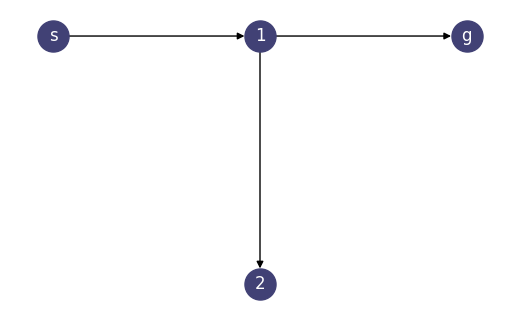

In [3]:
########################
###   グラフデータ   ###
########################
import networkx as nx
G = nx.DiGraph()
G.add_edges_from([('s', 1), (1, 2), (1, 'g')])
plt.figure(figsize=(5, 3))
pos = {'s':[-1, 0], 1:[0, 0], 2:[0, -1], 'g': [1, 0]}
nx.draw(G, pos=pos, node_color="#414175", node_size=500, font_color="#fff", with_labels=True)

### **QUBOの式に変換**
上のグラフの経路問題を量子アニーリングで解けるようにQUBOの式に変換します。 \
QUBOの式を作成するには `pyqubo` というフレームワークを用いると作成しやすいです。

In [4]:
########################
####    QUBO変換    ####
########################
from pyqubo import Binary
r_s1 = Binary("s->1")
r_12 = Binary("1->2")
r_1g = Binary("1->g")

weight = 1000
QUBO_Obj = r_s1 + r_12 + r_1g
QUBO_Penalty = (r_s1 - 1) ** 2 + (r_s1 - r_12 - r_1g) ** 2 + (1 - r_1g) ** 2
QUBO = QUBO_Obj + weight * QUBO_Penalty

print(f">>> QUBO: {QUBO}")

>>> QUBO: ((1000.000000 * (((1.000000 + (-1.000000 * Binary('1->g'))) * (1.000000 + (-1.000000 * Binary('1->g')))) + ((Binary('s->1') + -1.000000) * (Binary('s->1') + -1.000000)) + (((-1.000000 * Binary('1->g')) + Binary('s->1') + (-1.000000 * Binary('1->2'))) * ((-1.000000 * Binary('1->g')) + Binary('s->1') + (-1.000000 * Binary('1->2')))))) + Binary('1->g') + Binary('s->1') + Binary('1->2'))


## **Step2 量子：QUBOを元にアニーリングを行う**

D-Wave Systems社の量子アニーリングを用いて QUBO の解を見つけます。

・入力データには量子アニーリングの設定をしています。\
`DWAVE_TOKEN` には [D-wave Leap](https://cloud.dwavesys.com/leap/) から取得したトークンを入力してください。\
（トークンを入力しなかった場合にはシミュレータが動きます。）

`DWAVE_DEVICE_NAME` には実際に動かす量子コンピュータの名前を入力してください。\
量子コンピュータの種類は [D-wave Leap](https://cloud.dwavesys.com/leap/) の Solvers に一覧があります。

<table>
    <tr>
        <th>デバイス名</th>
        <td>Advantage_system5.4</td>
        <td>Advantage2_prototype2.5</td>
        <td>Advantage_system4.1</td>
        <td>Advantage_system6.4</td>
    </tr>
    <tr>
        <th>量子ビット</th>
        <td>5614</td>
        <td>1216</td>
        <td>5627</td>
        <td>5612</td>
    </tr>
    <tr>
        <th>トポロジー</th>
        <td>pegasus</td>
        <td>zephyr</td>
        <td>pegasus</td>
        <td>pegasus</td>
    </tr>
</table>

ここでは実行したデバイスと最終結果が表示されます。

In [5]:
from neal import SimulatedAnnealingSampler
from dwave.system import DWaveSampler, EmbeddingComposite

########################
####   入力データ   ####
########################
# アニーリング設定
SHOTS = 1000
DWAVE_TOKEN=""
DWAVE_DEVICE_NAME="Advantage_system5.4"

########################
##  量子アニーリング  ##
########################
qubo_model = QUBO.compile()
qubo_compiled, offset = qubo_model.to_qubo()

if not DWAVE_TOKEN:
    sampler = SimulatedAnnealingSampler()
    device = "SimulatedAnnealingSampler"
else:
    REGION = "eu-central-1" if DWAVE_DEVICE_NAME == "Advantage_system5.4" else "na-west-1"
    sampler = EmbeddingComposite(DWaveSampler(region=REGION, token=DWAVE_TOKEN, solver={"name": DWAVE_DEVICE_NAME}))
    device = sampler.properties['child_properties']['chip_id'] + " (DWaveSampler)"

sampleset = sampler.sample_qubo(qubo_compiled, num_reads=SHOTS, label="Quantum Annealing (Oita Quantum)")
answer = sampleset.first.sample
energy = sampleset.first.energy

print(f">>> Device: {device}")
print(f">>> Answer: {answer}")
print(f">>> Energy: {energy}")

>>> Device: SimulatedAnnealingSampler
>>> Answer: {'1->2': 0, '1->g': 1, 's->1': 1}
>>> Energy: -1998.0


## **Step3 古典：実行結果をもとに評価を行う**

Step2で求めた量子アニーリングの結果から実際の経路を求めます。

経路は赤色で表示されます。

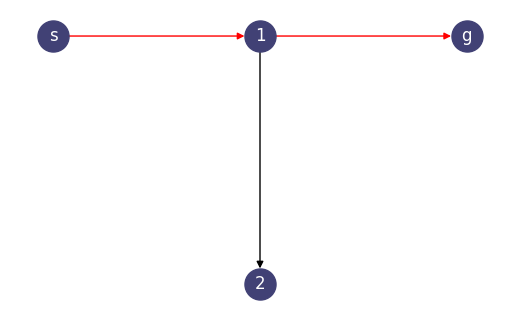

In [6]:
########################
###   グラフデータ   ###
########################
import networkx as nx
G = nx.DiGraph()
G.add_edges_from([('s', 1), (1, 2), (1, 'g')])

edge_color = []
for s, g in G.edges():
    v = answer[f'{s}->{g}']
    if v == 0:
        edge_color.append('k')
    else:
        edge_color.append('r')

plt.figure(figsize=(5, 3))
pos = {'s':[-1, 0], 1:[0, 0], 2:[0, -1], 'g': [1, 0]}
nx.draw(G, pos=pos, node_color="#414175", font_color="#fff", node_size=500, edge_color=edge_color, with_labels=True)

## **全体のソースコード**
全てのStepをもとに全体のソースコードは以下の通りです。

>>> QUBO: ((1000.000000 * (((1.000000 + (-1.000000 * Binary('1->g'))) * (1.000000 + (-1.000000 * Binary('1->g')))) + ((Binary('s->1') + -1.000000) * (Binary('s->1') + -1.000000)) + (((-1.000000 * Binary('1->g')) + Binary('s->1') + (-1.000000 * Binary('1->2'))) * ((-1.000000 * Binary('1->g')) + Binary('s->1') + (-1.000000 * Binary('1->2')))))) + Binary('1->g') + Binary('s->1') + Binary('1->2'))
>>> Device: SimulatedAnnealingSampler
>>> Answer: {'1->2': 0, '1->g': 1, 's->1': 1}
>>> Energy: -1998.0


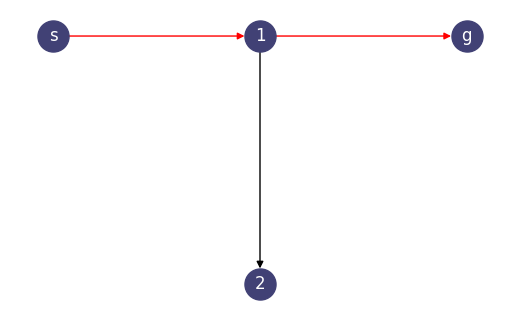

In [7]:
from dwave.system import DWaveSampler, EmbeddingComposite
from neal import SimulatedAnnealingSampler
from pyqubo import Binary
import networkx as nx

########################
####   入力データ   ####
########################
# アニーリング設定
weight = 1000
SHOTS = 1000
DWAVE_TOKEN=""
DWAVE_DEVICE_NAME="Advantage_system5.4"

########################
####    QUBO変換    ####
########################
r_s1 = Binary("s->1")
r_12 = Binary("1->2")
r_1g = Binary("1->g")

QUBO_Obj = r_s1 + r_12 + r_1g
QUBO_Penalty = (r_s1 - 1) ** 2 + (r_s1 - r_12 - r_1g) ** 2 + (1 - r_1g) ** 2
QUBO = QUBO_Obj + weight * QUBO_Penalty

print(f">>> QUBO: {QUBO}")

########################
##  量子アニーリング  ##
########################
qubo_model = QUBO.compile()
qubo_compiled, offset = qubo_model.to_qubo()

if not DWAVE_TOKEN:
    sampler = SimulatedAnnealingSampler()
    device = "SimulatedAnnealingSampler"
else:
    REGION = "eu-central-1" if DWAVE_DEVICE_NAME == "Advantage_system5.4" else "na-west-1"
    sampler = EmbeddingComposite(DWaveSampler(region=REGION, token=DWAVE_TOKEN, solver={"name": DWAVE_DEVICE_NAME}))
    device = sampler.properties['child_properties']['chip_id'] + " (DWaveSampler)"

sampleset = sampler.sample_qubo(qubo_compiled, num_reads=SHOTS, label="Quantum Annealing (Oita Quantum)")
answer = sampleset.first.sample
energy = sampleset.first.energy

print(f">>> Device: {device}")
print(f">>> Answer: {answer}")
print(f">>> Energy: {energy}")

########################
###   グラフデータ   ###
########################
G = nx.DiGraph()
G.add_edges_from([('s', 1), (1, 2), (1, 'g')])

edge_color = []
for s, g in G.edges():
    v = answer[f'{s}->{g}']
    if v == 0:
        edge_color.append('k')
    else:
        edge_color.append('r')

plt.figure(figsize=(5, 3))
pos = {'s':[-1, 0], 1:[0, 0], 2:[0, -1], 'g': [1, 0]}
nx.draw(G, pos=pos, node_color="#414175", font_color="#fff", node_size=500, edge_color=edge_color, with_labels=True)

---
## **<small>資料作成</small>**
<small>DEVEL株式会社</small> \
<small>最終更新日2024年11月20日</small>